In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch as t
import torch.nn as nn
import torch.nn.functional as F
from beartype import beartype as typed
from beartype.door import die_if_unbearable as assert_type
from datasets import load_dataset
from jaxtyping import Float, Int, Bool
from typing import Callable
from torch import Tensor as TT
from transformers import AutoModelForCausalLM, AutoTokenizer
from einops import einops as ein

%load_ext autoreload
%autoreload 2

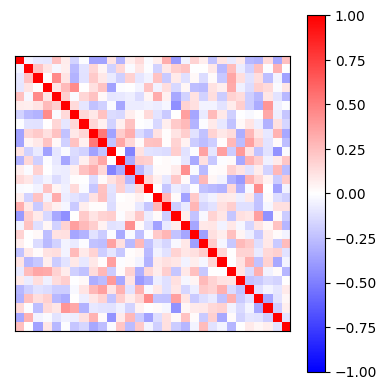

In [81]:
from utils import seed_everything

seed_everything(42)

hidden_dim = 30
input_dim = 30
# emb: Float[TT, "hidden_dim input_dim"] = t.cat([(-1) ** i * t.eye(input_dim) for i in range(2)], dim=0)
emb: Float[TT, "hidden_dim input_dim"] = t.randn(hidden_dim, input_dim)

emb_cos: Float[TT, "hidden_dim hidden_dim"] = F.cosine_similarity(emb[:, None], emb[None, :], dim=-1)
assert emb_cos[3, 5] == F.cosine_similarity(emb[3], emb[5], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(emb_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

100%|██████████| 20/20 [00:01<00:00, 19.58it/s,  loss=4.35, nonzero=34.20 / 50, nonorth=353.10]


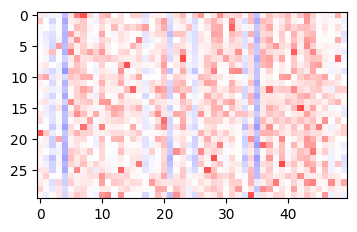

0.55 [ 0.67 0.49 0.62 0.38 0.50 0.45 0.63 0.70 0.69 0.48 0.39 0.36 0.60 0.40 0.45 0.70 0.44 0.58 0.56 0.65 0.47 0.60 0.52 0.68 0.72 0.67 0.43 0.53 0.45 0.68 ]


100%|██████████| 20/20 [00:01<00:00, 19.00it/s,  loss=0.23, nonzero=35.81 / 50, nonorth=1020.69]


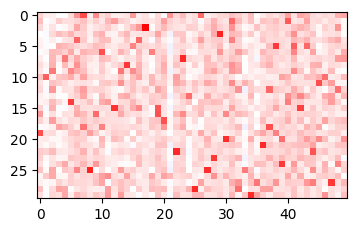

0.73 [ 0.70 0.64 0.97 0.87 0.60 0.77 0.68 0.85 0.79 0.54 0.62 0.69 0.60 0.58 0.76 0.80 0.68 0.68 0.69 0.68 0.82 0.84 0.84 0.79 0.77 0.87 0.44 0.77 0.85 0.83 ]


100%|██████████| 20/20 [00:01<00:00, 19.26it/s,  loss=0.03, nonzero=32.96 / 50, nonorth=913.09]


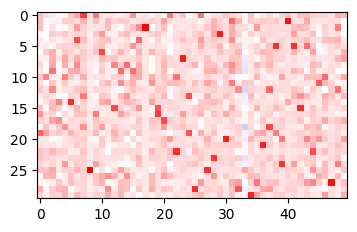

0.78 [ 0.76 0.94 0.99 0.91 0.70 0.82 0.73 0.91 0.59 0.59 0.58 0.66 0.59 0.70 0.83 0.83 0.78 0.70 0.72 0.67 0.88 0.88 0.83 0.80 0.80 0.99 0.44 0.96 0.83 0.87 ]


100%|██████████| 20/20 [00:01<00:00, 14.23it/s,  loss=0.02, nonzero=31.20 / 50, nonorth=863.49]


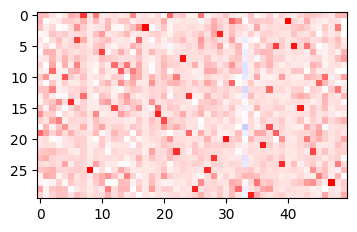

0.80 [ 0.79 0.99 0.99 0.88 0.74 0.93 0.74 0.93 0.56 0.65 0.65 0.60 0.59 0.82 0.83 0.91 0.86 0.72 0.70 0.62 0.93 0.89 0.82 0.80 0.84 0.99 0.50 0.99 0.85 0.88 ]


100%|██████████| 20/20 [00:01<00:00, 17.23it/s,  loss=0.02, nonzero=30.83 / 50, nonorth=831.56]


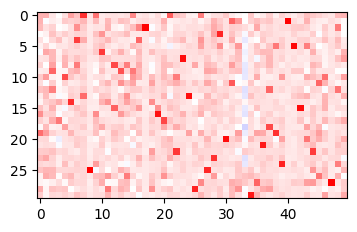

0.83 [ 0.81 0.99 0.99 0.86 0.76 0.96 0.77 0.94 0.71 0.68 0.70 0.64 0.60 0.94 0.83 0.95 0.93 0.72 0.71 0.80 0.95 0.90 0.79 0.81 0.86 0.99 0.54 0.99 0.86 0.89 ]


100%|██████████| 20/20 [00:01<00:00, 19.24it/s,  loss=0.02, nonzero=30.80 / 50, nonorth=786.49]


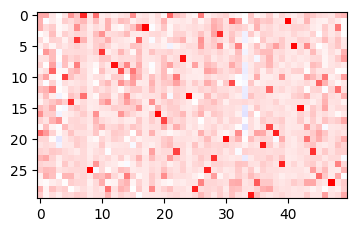

0.85 [ 0.84 0.99 0.99 0.83 0.77 0.97 0.78 0.94 0.93 0.69 0.74 0.70 0.59 0.99 0.82 0.97 0.97 0.73 0.73 0.87 0.96 0.90 0.80 0.81 0.87 0.99 0.57 0.99 0.86 0.90 ]


100%|██████████| 20/20 [00:01<00:00, 18.67it/s,  loss=0.02, nonzero=31.10 / 50, nonorth=770.44]


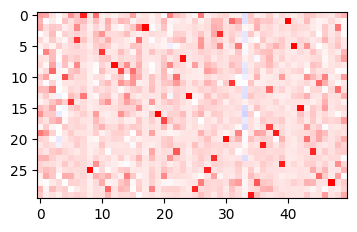

0.86 [ 0.87 0.99 0.99 0.82 0.78 0.98 0.79 0.94 0.96 0.71 0.68 0.78 0.59 0.99 0.80 0.97 0.99 0.73 0.75 0.89 0.96 0.90 0.85 0.82 0.88 0.98 0.58 0.99 0.85 0.91 ]


100%|██████████| 20/20 [00:01<00:00, 19.03it/s,  loss=0.02, nonzero=31.60 / 50, nonorth=738.26]


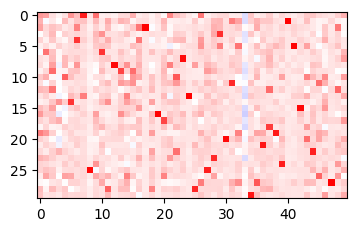

0.86 [ 0.88 0.99 0.99 0.82 0.80 0.98 0.80 0.95 0.97 0.73 0.65 0.84 0.60 0.99 0.80 0.97 0.99 0.72 0.76 0.90 0.96 0.91 0.87 0.83 0.89 0.96 0.60 0.99 0.85 0.91 ]


100%|██████████| 20/20 [00:01<00:00, 15.25it/s,  loss=0.02, nonzero=31.82 / 50, nonorth=731.24]


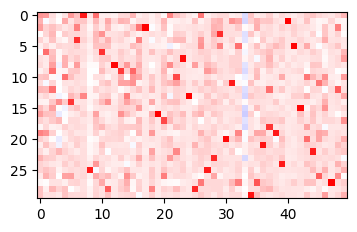

0.87 [ 0.90 0.99 0.99 0.83 0.80 0.98 0.80 0.95 0.97 0.77 0.71 0.89 0.63 0.99 0.79 0.97 0.99 0.72 0.78 0.90 0.96 0.92 0.89 0.83 0.90 0.89 0.62 0.99 0.84 0.91 ]


100%|██████████| 20/20 [00:01<00:00, 18.68it/s,  loss=0.02, nonzero=31.90 / 50, nonorth=736.97]


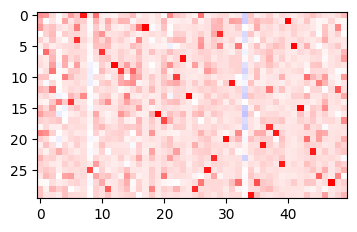

0.87 [ 0.91 0.99 0.99 0.83 0.81 0.97 0.80 0.95 0.97 0.79 0.76 0.91 0.65 0.99 0.79 0.97 0.99 0.70 0.81 0.90 0.96 0.92 0.89 0.84 0.90 0.89 0.62 0.99 0.83 0.92 ]


In [82]:
from utils import SparseAutoEncoder, fit_sae, ls

# seed_everything(42)


n_samples = 10**4
dict_dim = 50

gt: Int[TT, "n_samples hidden_dim"] = t.bernoulli(t.full((n_samples, hidden_dim), 0.1))
obs: Float[TT, "n_samples input_dim"] = gt @ emb


sae = SparseAutoEncoder(input_dim, dict_dim)
dist = t.zeros((hidden_dim, dict_dim))

for it in range(10):
    fit_sae(sae, obs, lr=1e-2, l1=1e-2, alpha=1e-4, epochs=20, batch_size=2500)
    guess = sae.encode(obs)

    for true_feature in range(hidden_dim):
        for dict_feature in range(dict_dim):
            y = gt[:, true_feature].float()
            p = guess[:, dict_feature].detach()
            dist[true_feature, dict_feature] = F.cosine_similarity(p, y, dim=-1)

    plt.figure(figsize=(4, 4))
    plt.imshow(dist, vmin=-1, vmax=1, cmap="bwr")
    plt.show()
    best = dist.max(dim=1).values
    print(ls(best.mean()), ls(best))

[50, 20]


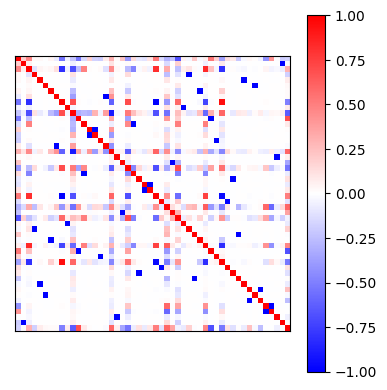

[50, 10000]


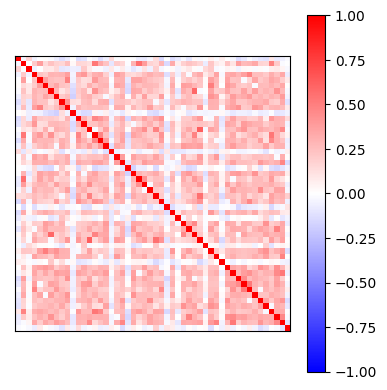

In [77]:
from utils import sh

W = sae.weight.detach().T
print(sh(W))
W_cos = F.cosine_similarity(W[:, None], W[None, :], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(W_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()

W = guess.T.detach()
print(sh(W))
W_cos = F.cosine_similarity(W[:, None], W[None, :], dim=-1)
plt.figure(figsize=(4, 4))
plt.imshow(W_cos, vmin=-1, vmax=1, cmap="bwr")
plt.colorbar()
plt.xticks([])
plt.yticks([])
plt.tight_layout()
plt.show()